In [1]:
import numpy as np
import pandas as pd
import os
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets, transforms
from torchvision.models import efficientnet_b0, efficientnet_v2_s
from torchvision.models import EfficientNet_B0_Weights, EfficientNet_V2_S_Weights
import torchvision.transforms as transforms
from torchinfo import summary
from tqdm import tqdm

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
BATCH_SIZE = 512

mean, std = (0.5,), (0.5,)

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

trainset = datasets.MNIST('../data/MNIST/', download=True, train=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = datasets.MNIST('../data/MNIST/', download=True, train=False, transform=transform)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

In [4]:
class PredictionHead(nn.Module):
    def __init__(self, feature_dims):
        super(PredictionHead, self).__init__()
        self.activate = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

        self.fc = nn.Sequential()
        for i in range(len(feature_dims)-1):
            # self.fc.add_module(f'drop_{i}', self.dropout)
            self.fc.add_module(f'fc_{i}', nn.Linear(feature_dims[i], feature_dims[i+1]))
            if i != len(feature_dims)-2:
                self.fc.add_module(f'a_{i}', self.activate)

    def forward(self, x):
        x = self.fc(x)

        return x

In [5]:
def new_custom_effb0(hidden_features):
    model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
    feature = [1280]
    feature.extend(hidden_features)
    model.classifier = PredictionHead(feature).cuda()

    new_conv_1 = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    new_conv_1.weight.data = model.features[0][0].weight.data.mean(dim=1, keepdim=True).clone().detach()

    model.features[0][0] = new_conv_1
    model = model.to(device)

    return model

In [6]:
# model = new_custom_effb0([512, 256, 64, 10])
# summary(model, input_size=(BATCH_SIZE, 1, 28, 28), device=device.type)

In [7]:
LR = 5e-5
NUM_EPOCHES = 25
head_features = [512, 256, 64, 10]
model = new_custom_effb0(head_features)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHES)

In [8]:
avg_train_loss, avg_val_loss = [], []
for i in range(NUM_EPOCHES):
    model.train()
    print("-"*80)
    print(f"Learning Rate: {scheduler.get_last_lr()[0]:.8f}")
    for x, y in tqdm(trainloader, desc=f'Epoch {i+1}/{NUM_EPOCHES}', unit='batch'):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
    avg_train_loss.append(loss.item())

    with torch.no_grad():
        model.eval()
        val_loss = 0
        for x, y in tqdm(testloader, desc='Validation', unit='batch'):
            x, y = x.to(device), y.to(device)

            output = model(x)
            loss = criterion(output, y)
            val_loss += loss.item()
        avg_val_loss.append(val_loss / len(testloader))
    print(f'Train Loss: {avg_train_loss[-1]:.4f}, Validation Loss: {avg_val_loss[-1]:.4f}')
    print("-"*80)
    print()
    scheduler.step()

--------------------------------------------------------------------------------
Learning Rate: 0.00005000


Validation: 100%|██████████| 20/20 [00:00<00:00, 35.08batch/s]


Train Loss: 1.3369, Validation Loss: 1.2761
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.00004980


Validation: 100%|██████████| 20/20 [00:00<00:00, 36.22batch/s]


Train Loss: 0.5869, Validation Loss: 0.3540
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.00004921


Validation: 100%|██████████| 20/20 [00:00<00:00, 36.29batch/s]


Train Loss: 0.2654, Validation Loss: 0.1645
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.00004824


Validation: 100%|██████████| 20/20 [00:00<00:00, 36.09batch/s]


Train Loss: 0.1362, Validation Loss: 0.1296
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.00004691


Validation: 100%|██████████| 20/20 [00:00<00:00, 36.37batch/s]


Train Loss: 0.2877, Validation Loss: 0.1124
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.00004523


Validation: 100%|██████████| 20/20 [00:00<00:00, 35.84batch/s]


Train Loss: 0.2650, Validation Loss: 0.1004
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.00004322


Validation: 100%|██████████| 20/20 [00:00<00:00, 35.17batch/s]


Train Loss: 0.2525, Validation Loss: 0.0889
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.00004094


Validation: 100%|██████████| 20/20 [00:00<00:00, 34.70batch/s]


Train Loss: 0.0610, Validation Loss: 0.0866
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.00003840


Validation: 100%|██████████| 20/20 [00:00<00:00, 35.51batch/s]


Train Loss: 0.1201, Validation Loss: 0.0844
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.00003564


Validation: 100%|██████████| 20/20 [00:00<00:00, 35.91batch/s]


Train Loss: 0.1010, Validation Loss: 0.0836
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.00003273


Validation: 100%|██████████| 20/20 [00:00<00:00, 36.42batch/s]


Train Loss: 0.0540, Validation Loss: 0.0785
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.00002968


Validation: 100%|██████████| 20/20 [00:00<00:00, 35.15batch/s]


Train Loss: 0.1535, Validation Loss: 0.0765
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.00002657


Validation: 100%|██████████| 20/20 [00:00<00:00, 35.76batch/s]


Train Loss: 0.0451, Validation Loss: 0.0868
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.00002343


Validation: 100%|██████████| 20/20 [00:00<00:00, 35.87batch/s]


Train Loss: 0.1688, Validation Loss: 0.0795
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.00002032


Validation: 100%|██████████| 20/20 [00:00<00:00, 36.39batch/s]


Train Loss: 0.0407, Validation Loss: 0.0767
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.00001727


Validation: 100%|██████████| 20/20 [00:00<00:00, 35.69batch/s]


Train Loss: 0.0078, Validation Loss: 0.0833
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.00001436


Validation: 100%|██████████| 20/20 [00:00<00:00, 36.99batch/s]


Train Loss: 0.0446, Validation Loss: 0.0763
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.00001160


Validation: 100%|██████████| 20/20 [00:00<00:00, 36.14batch/s]


Train Loss: 0.1543, Validation Loss: 0.0838
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.00000906


Validation: 100%|██████████| 20/20 [00:00<00:00, 36.72batch/s]


Train Loss: 0.2367, Validation Loss: 0.0753
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.00000678


Validation: 100%|██████████| 20/20 [00:00<00:00, 33.45batch/s]


Train Loss: 0.0654, Validation Loss: 0.0783
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.00000477


Validation: 100%|██████████| 20/20 [00:00<00:00, 36.23batch/s]


Train Loss: 0.1516, Validation Loss: 0.0803
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.00000309


Validation: 100%|██████████| 20/20 [00:00<00:00, 36.04batch/s]


Train Loss: 0.0732, Validation Loss: 0.0785
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.00000176


Validation: 100%|██████████| 20/20 [00:00<00:00, 34.45batch/s]


Train Loss: 0.0678, Validation Loss: 0.0776
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.00000079


Validation: 100%|██████████| 20/20 [00:00<00:00, 36.39batch/s]


Train Loss: 0.0169, Validation Loss: 0.0740
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.00000020


Validation: 100%|██████████| 20/20 [00:00<00:00, 35.65batch/s]

Train Loss: 0.0087, Validation Loss: 0.0750
--------------------------------------------------------------------------------



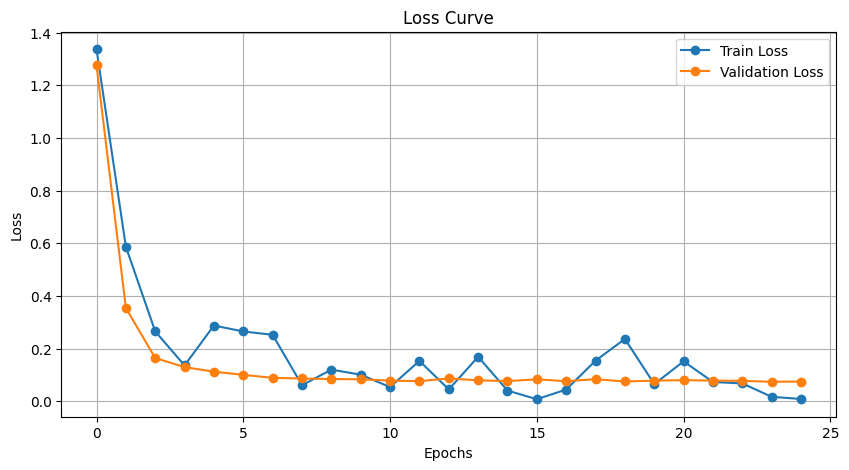

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(avg_train_loss, label='Train Loss', marker='o')
plt.plot(avg_val_loss, label='Validation Loss', marker='o')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [45]:
torch.save(model.state_dict(), './model/custom_effb0_mnist.pth')

In [52]:
best_model = new_custom_effb0(head_features)
best_model.load_state_dict(torch.load('./model/custom_effb0_mnist.pth'))

<All keys matched successfully>

In [49]:
a = testloader.dataset[1]
print(a[0].shape, a[1]) 

torch.Size([1, 28, 28]) 2


In [54]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    accuracy = np.trace(cm) / np.sum(cm)
    print("Accuracy: ", accuracy)

Testing: 100%|██████████| 20/20 [00:00<00:00, 34.74batch/s]


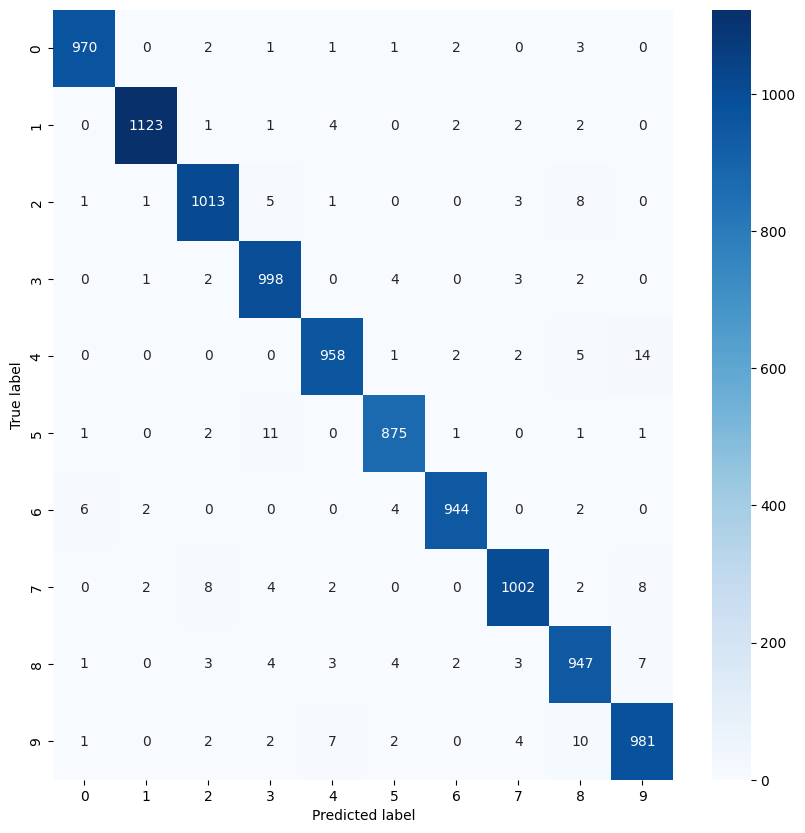

Accuracy:  0.9811


In [55]:
y_true_test = []
y_pred_test = []
best_model.to(device)
best_model.eval()
with torch.no_grad():
    for x, y in tqdm(testloader, desc='Testing', unit='batch'):
        x, y = x.to(device), y.to(device)

        output = best_model(x)
        _, predicted = torch.max(output, 1)

        y_true_test.extend(y.cpu().numpy())
        y_pred_test.extend(predicted.cpu().numpy())
plot_confusion_matrix(y_true_test, y_pred_test, classes=[str(i) for i in range(10)])